In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy

import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/Users/chstansbury/PyCharmProjects/python-arpes/')

In [26]:
# Core #
import json
import os
import re

# IO
import h5py

# Science And Plotting #
import matplotlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import holoviews as hv
import holoviews.util
hv.extension('matplotlib')

sns.set()

from scipy import optimize

# Analysis #
import arpes
import arpes.config
from arpes.models.spectrum import DLD_Spectrum_factory, load_SES
from arpes.models.view import View

# Jupyter #
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Configure Jupyter #
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/chstansbury/anaconda/envs/python_arpes/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
from arpes.pipelines import convert_scan_to_kspace
from arpes.utilities import walk_scans
from arpes.config import SOURCE_PATH
from arpes.io import load_dataset
import os.path

In [4]:
datasets = list(walk_scans(os.path.join(SOURCE_PATH, 'datasets/RhSn2')))

In [5]:
%%opts Curve {+framewise}
from arpes.plotting.interactive import autoview
scan = load_dataset(convert_scan_to_kspace(datasets[-1]['id']))
region = scan.sel(eV=slice(-0.7, 0), kp=slice(-1.2, 1.2))
autoview(region)

:AdjointLayout
   :DynamicMap   []
      :Overlay
         .Image.I :Image   [kp,eV]   (z)
         .HLine.I :HLine   [x,y]
         .VLine.I :VLine   [x,y]
   :DynamicMap   []
      :Curve   [kp]   (z)
   :DynamicMap   []
      :Curve   [eV]   (z)

In [6]:
from arpes.models.band import Band, VoigtBand, BackgroundBand
from arpes.analysis import fit_bands

# Preliminary Band Fitting

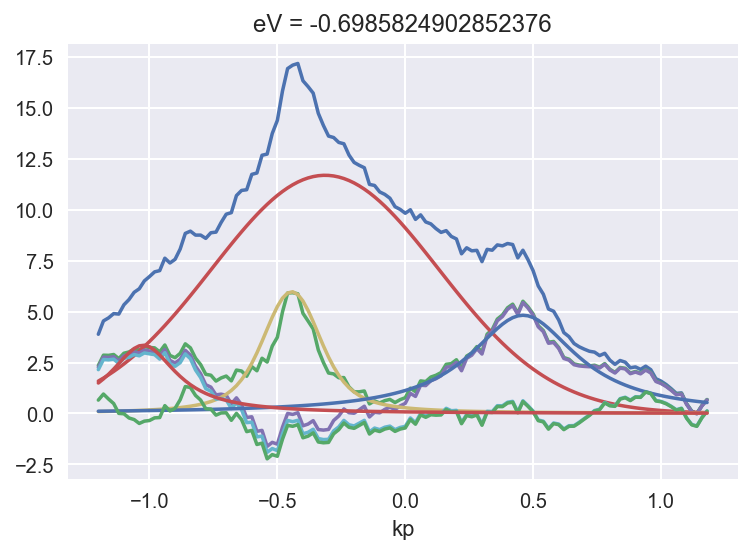

In [7]:
fit_results, bands, residual = fit_bands(region, [{ 
        'band': BackgroundBand('fat_background'),
        'constraints': {
            'amplitude': {'max': 13, 'min': 7},
            'sigma': {'min': 0.3},
        },
    },
    { 
        'band': VoigtBand('left'),
        'constraints': {'amplitude': {'min': 2},
                        'sigma': {'max': 0.08},
                        'center': {'value': -0.45}},
    },
    {
        'band': Band('right'),
        'constraints': {'amplitude': {'min': 0}},
    },
    {
        'band': Band('far_left'),
        'constraints': {'amplitude': {'min': 0}},
    },
], direction='mdc', step='initial', background=arpes.fits.ConstantModel)

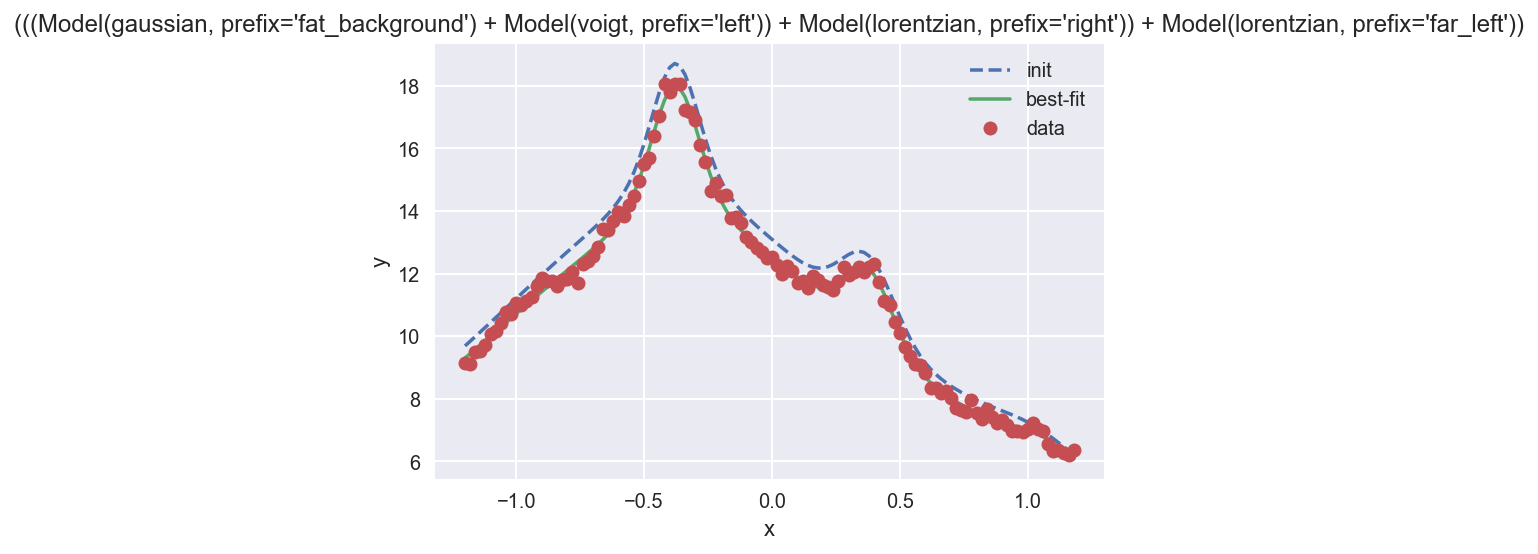

In [8]:
fit_results.values[133].plot_fit()


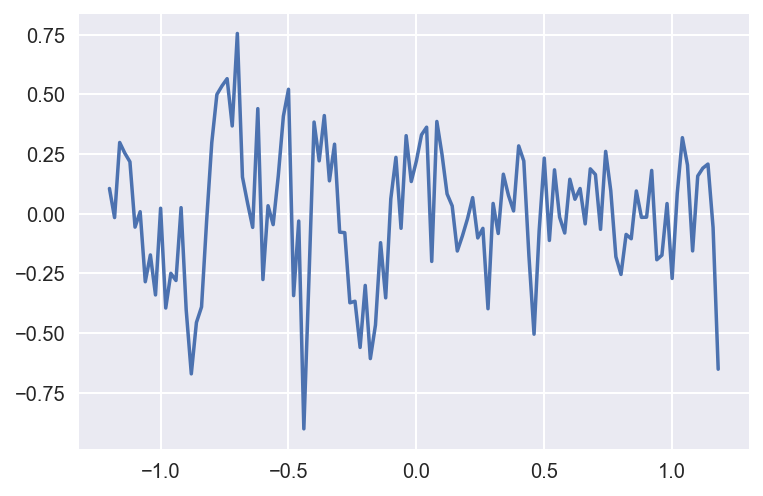

In [9]:
plt.plot(region.coords['kp'], fit_results.values[20].residual)


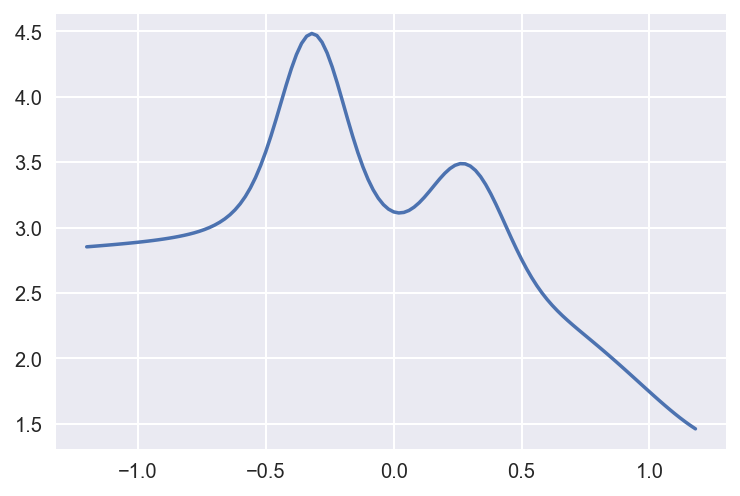

In [10]:
plt.plot(region.coords['kp'], fit_results.values[349].best_fit)

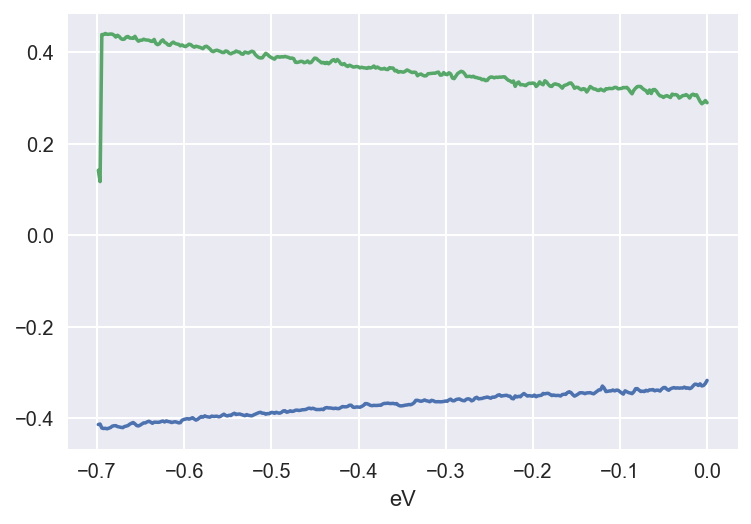

In [11]:
from arpes.utilities import apply_dataarray
apply_dataarray(fit_results, np.vectorize(lambda x: x.params['leftcenter'].value)).plot()
#apply_dataarray(fit_results, np.vectorize(lambda x: x.params['rightcenter'].value)).plot()
apply_dataarray(fit_results, np.vectorize(lambda x: x.params['fat_backgroundcenter'].value)).plot()


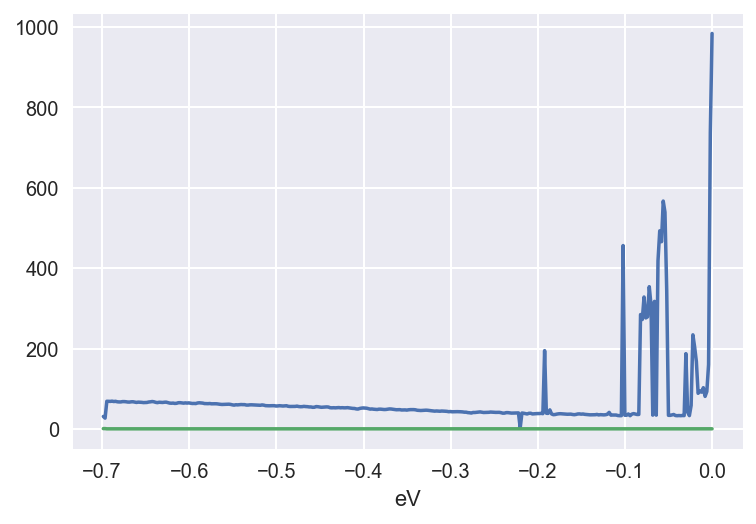

In [12]:
#apply_dataarray(fit_results, np.vectorize(lambda x: x.params['leftcenter'].value)).plot()
apply_dataarray(fit_results, np.vectorize(lambda x: x.params['far_leftamplitude'].value)).plot()
apply_dataarray(fit_results, np.vectorize(lambda x: x.params['fat_backgroundsigma'].value)).plot()

# Restoring Band Identity

Sometimes through the fitting process, or across a place where there is a nodal point in the band structure, the identities of the bands can become mixed up. We can try to deconvolve this by iterating over the bands and matching them on the basis of total distance

In [13]:
test_fit = fit_results.values[20]

In [14]:
test_fit.model.components[0].prefix

'fat_background'

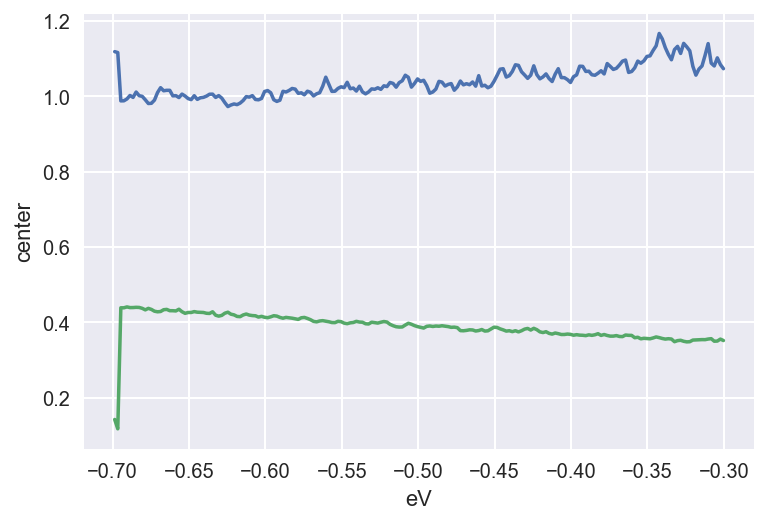

In [34]:
from arpes.analysis import unpack_bands_from_fit

bands = unpack_bands_from_fit(fit_results)
bands[2]._data.center.sel(eV=slice(-0.7, -0.3)).plot()
bands[0]._data.center.sel(eV=slice(-0.7, -0.3)).plot()

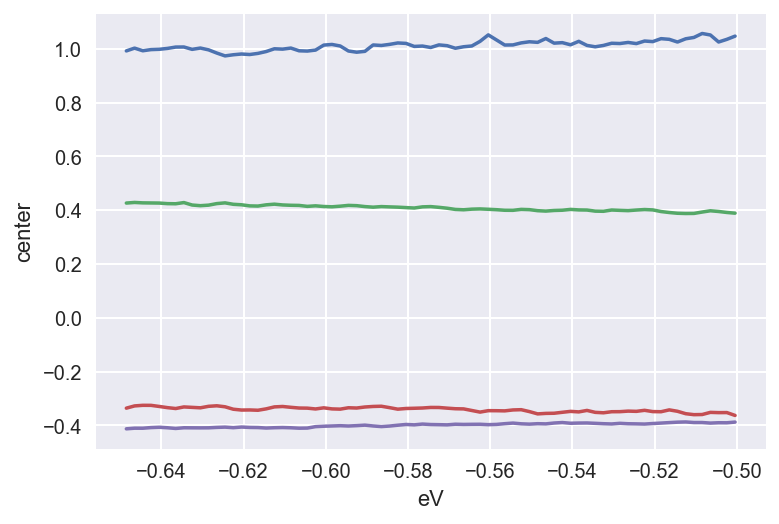

In [16]:
bands[2]._data.sel(eV=slice(-0.65, -0.5)).center.plot()
bands[0]._data.sel(eV=slice(-0.65, -0.5)).center.plot()
bands[3]._data.sel(eV=slice(-0.65, -0.5)).center.plot()
bands[1]._data.sel(eV=slice(-0.65, -0.5)).center.plot()

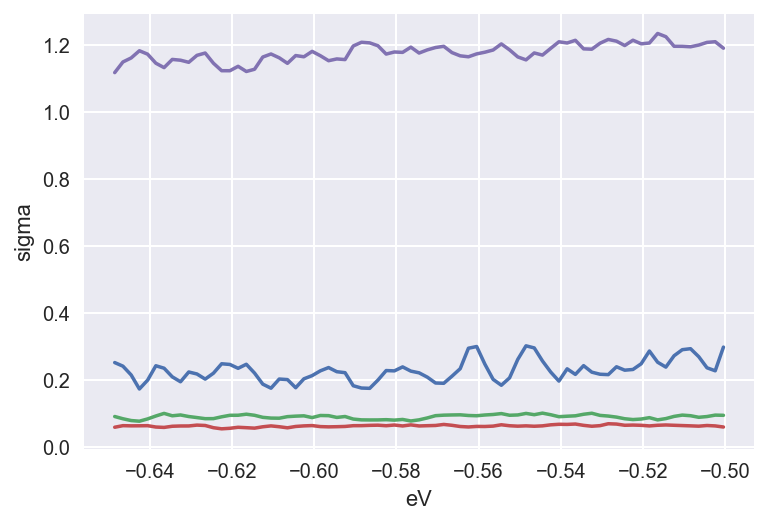

In [17]:
bands[2]._data.sel(eV=slice(-0.65, -0.5)).sigma.plot()
bands[0]._data.sel(eV=slice(-0.65, -0.5)).sigma.plot()
bands[1]._data.sel(eV=slice(-0.65, -0.5)).sigma.plot()
bands[3]._data.sel(eV=slice(-0.65, -0.5)).sigma.plot()

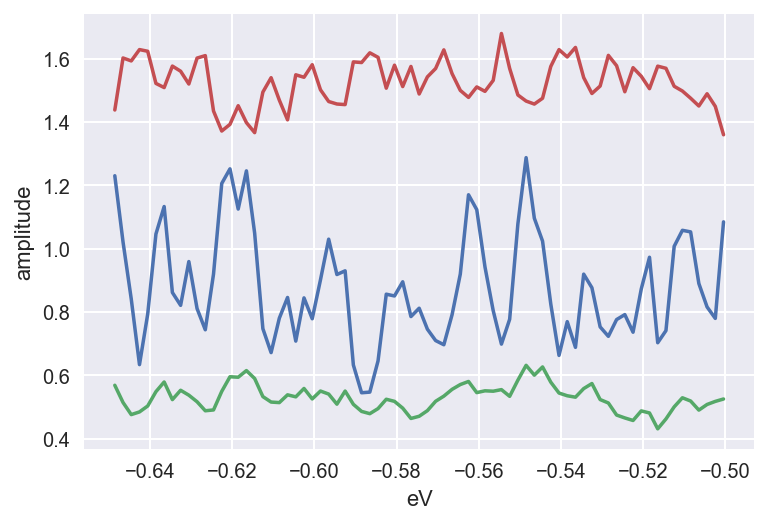

In [18]:
bands[2]._data.sel(eV=slice(-0.65, -0.5)).amplitude.plot()
bands[0]._data.sel(eV=slice(-0.65, -0.5)).amplitude.plot()
bands[1]._data.sel(eV=slice(-0.65, -0.5)).amplitude.plot()
#bands[3]._data.sel(eV=slice(-0.65, -0.5)).amplitude.plot()

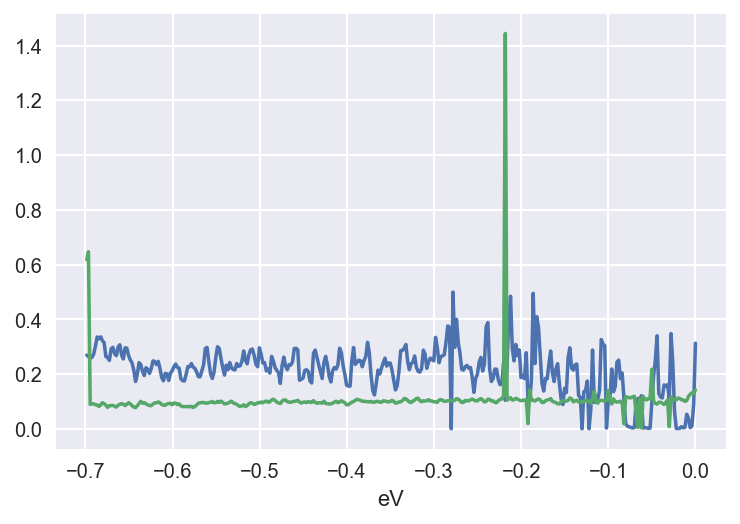

In [19]:
(bands[2]._data.sigma / (1 + bands[2]._data.sigma_stderr ** 2)).plot()
(bands[0]._data.sigma / (1 + bands[0]._data.sigma_stderr ** 2)).plot()

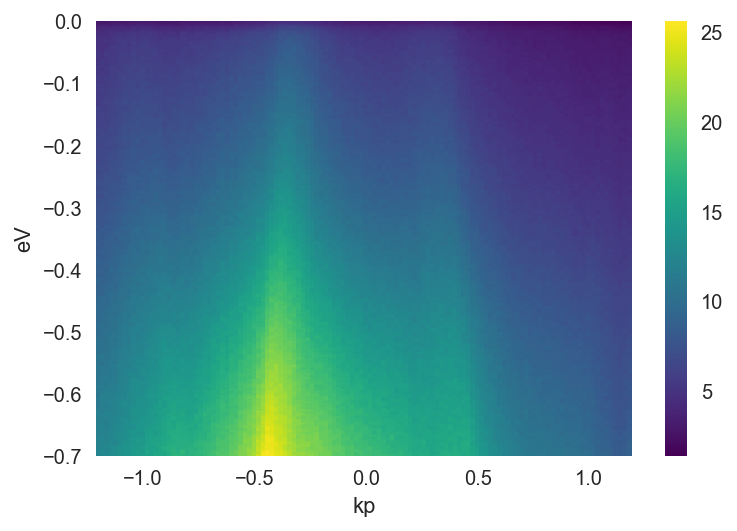

In [20]:
region.plot()

# Basic Dispersion Plotting

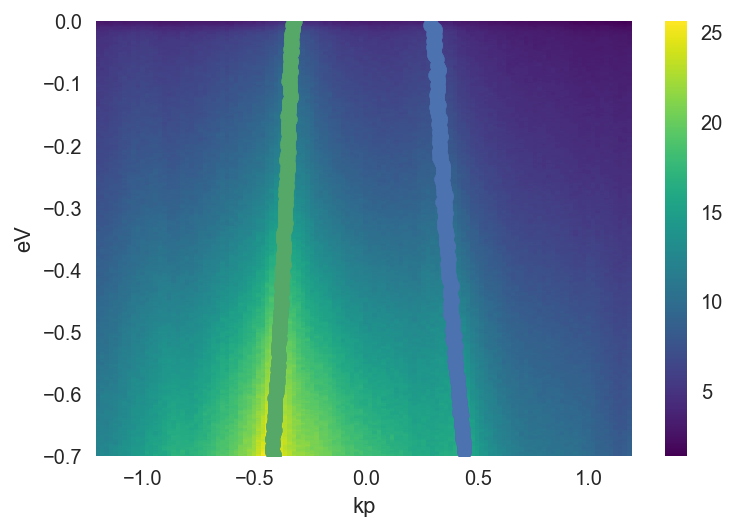

In [41]:
from arpes.plotting.dispersion import plot_dispersion
plot_dispersion(region, [bands[0], bands[1]])

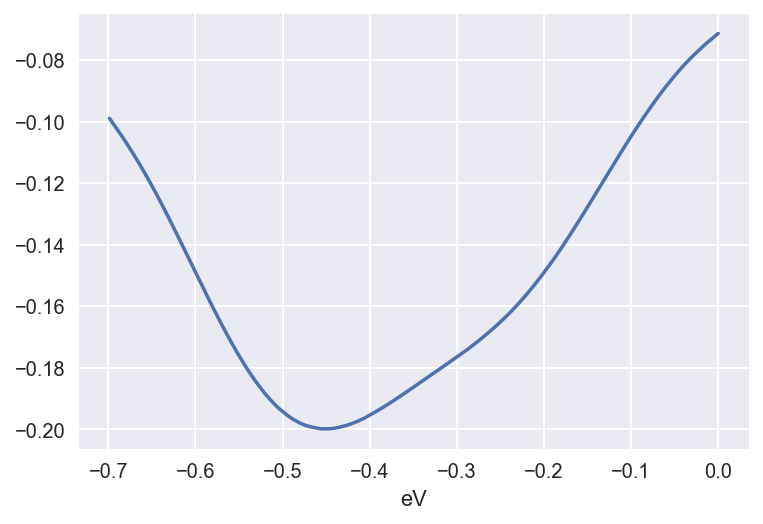

In [88]:
bands[0].velocity.plot()

In [89]:
region.attrs['provenance']

{'parent_id': 'b7995ac6-aa22-11e7-b1bd-6c40088ef8e6',
 'parents_provanence': {'parent_id': '3936abcc-a96f-11e7-a535-6c40088ef8e6',
  'parents_provanence': {'file': '/Users/chstansbury/Research/lanzara/data/RhSn2/hdf5/RhSn_019.h5',
   'parents_provenance': 'filesystem',
   'record': {'by': 'load_SES', 'what': 'Loaded SES dataset from HDF5.'},
   'time': '2017-10-05 15:57:13.050765'},
  'record': {'by': 'apply_quadratic_fermi_edge_correction',
   'correction': {'a': -0.00011451511793322441,
    'b': 0.0005341967036726452,
    'c': 0.003961417481788231},
   'what': 'Shifted Fermi edge to align at 0'},
  'time': '2017-10-05 16:12:54.398056'},
 'record': {'by': 'convert_to_kspace',
  'what': 'Automatically k-space converted'},
 'time': '2017-10-05 16:12:54.483870'}